## Ricker Model estimation with approximated likelihood ratios

Juan Pavez, March 2016.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.

For this, the Ricker classical populatiol model is used (this model shows near-chaotic dynamics). The ricker model is defined as:
$$ X_{t+1} = rX_t\exp(-X_t + e_t) $$
where $e_t$ is independent with $Normal(0,\sigma^2)$ distribution.
The process is not observed directly, instead samples with poisson distribution are observed.
$$ Y_t = Poisson(\phi X_t) $$
The Ricker model is an example of state space models.
We first only consider the time serie $X$ in order to study parameter estimation using approximated likelihood ratios on time series.
Here, the distribution is only conditioned by the previous value $p(x_t|x_{t-1})$. 
The joint probability distribution is then 
$$p_{x_t,...x_1}(x_t,...x_1;\theta) = \prod_{t=2}^T{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta)} * p_{x_1}(x_1;\theta)$$

or if we keep $x_1$ deterministic, the conditional likelihood can be used instead 
$$\prod_{t=2}^T{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta)}$$ . 

A recurrent neural network trained on the sequences $X' = [{x_t,x_{t-1}}]$ will approximate the posterior probability $p(y_t|x_t,x_{t-1})$ which is monotonic to the ratio $p(x_t|x_{t-1};\theta_0)/ p(x_t|x_{t-1};\theta_1)$

Then to compute the likelihood ratio :
$$\frac{L(\theta_0)}{L(\theta_1)} = \prod_{t=1}^T \frac{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta_0)}{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta_1)}$$
 we can replace the ratios $p(x_t|x_{t-1};\theta_0)/ p(x_t|x_{t-1};\theta_1)$  by the distribution of the score of the trained RNN $p(s([x_t,x_{t-1}])|\theta_0)/ p(s([x_t,x_{t-1}])|\theta_1)$.
 
Then, we can use maximum likelihood on the approximated likelihood ratios (keeping the ratio fixed) in order to estimate the parameters of the time series model.

We start by estimating the parameter $r$ from $\theta = (r,\sigma^2,\phi)$.



In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

np.random.seed(1234)

In [183]:
n_samples = 250000
r_value = np.exp(3.8)
sigma_2_value = 0.3**2
phi_value = 10.
def ricker(r=0.5, sigma_2=1., phi=0.1, start=0.1,n_timesteps=1000):
    noise = np.random.normal(0.,sigma_2, n_timesteps)
    time_serie = np.zeros(n_timesteps,dtype=np.float64)
    time_serie[0] = np.abs(noise[0])
    for i in range(1,n_timesteps):
        time_serie[i] = (r*time_serie[i-1]*np.exp(-time_serie[i-1] + noise[i]))
    
    sampled = np.zeros(n_timesteps // 50)
    sampled = np.array([np.random.poisson(phi*time_serie[i]) for i in range(0,n_timesteps,50)])
    return time_serie, sampled

serie1,sampled1 = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)

X_true,X_true_obs = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=1500,start=0.5)


1.30238978339e-07 22.624822249
1.31471280196e-16 44.8364725597
(5000,)


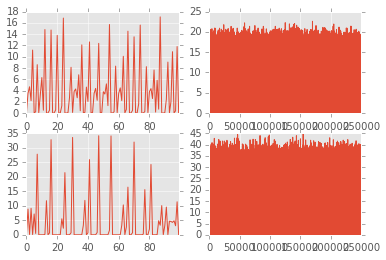

In [184]:
plt.figure(1)
plt.subplot(221)
ts = pd.Series(serie1)
ts[0:100].plot()
plt.subplot(222)
ts = pd.Series(serie1)
ts.plot()
plt.subplot(223)
ts = pd.Series(serie2)
ts[0:100].plot()
plt.subplot(224)
ts = pd.Series(serie2)
ts.plot()
print serie1.min(),serie1.max()
print serie2.min(),serie2.max()
print sampled1.shape


In [185]:
X = np.hstack((
     serie1,
     serie2)).reshape((n_samples*2,1))
y = np.zeros(n_samples*2, dtype=np.int)
y[n_samples:] = 1

max_len = 2
X0_serie = []
y0_serie = []
X1_serie = []
y1_serie = []

serie1 = serie1.reshape(serie1.shape[0],1)
serie2 = serie2.reshape(serie2.shape[0],1)
for i in xrange(serie1.shape[0]-max_len):
    X0_serie.append(serie1[i:i+max_len])
    X1_serie.append(serie2[i:i+max_len])
X0_serie = np.array(X0_serie)
X1_serie = np.array(X1_serie)

X_serie = np.vstack((
     X0_serie,
     X1_serie))
y_serie = np.zeros(X0_serie.shape[0]*2,dtype=np.int)
y_serie[X0_serie.shape[0]:] = 1


In [186]:
X_true = X_true.reshape(X_true.shape[0],1)
X_true_serie = []
for i in xrange(X_true.shape[0]-max_len):
    X_true_serie.append(X_true[i:i+max_len])
X_true_serie = np.array(X_true_serie)

In [187]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = Sequential()
model.add(SimpleRNN(4,input_shape=(max_len,1)))
model.add(Dense(4,activation='tanh'))
model.add(Dense(1,activation='sigmoid'))

#model.compile(loss='mean_squared_error', optimizer='rmsprop')
from keras_wrapper import KerasClassifier

clf = KerasClassifier(model=model, loss='mean_squared_error', optimizer='rmsprop', nb_epoch=50, verbose=2)
#clf = make_pipeline(StandardScaler(),as_classifier(clf))

clf.fit(X=X_serie, y=y_serie)

#clf.fit(X=X_serie, y=y_serie,nb_epoch=3,batch_size=32,verbose=2)

Epoch 1/50
4s - loss: 0.2293
Epoch 2/50
4s - loss: 0.1942
Epoch 3/50
4s - loss: 0.1676
Epoch 4/50
4s - loss: 0.1551
Epoch 5/50
4s - loss: 0.1487
Epoch 6/50
4s - loss: 0.1449
Epoch 7/50
4s - loss: 0.1423
Epoch 8/50
5s - loss: 0.1402
Epoch 9/50
6s - loss: 0.1386
Epoch 10/50
7s - loss: 0.1372
Epoch 11/50
5s - loss: 0.1360
Epoch 12/50
5s - loss: 0.1348
Epoch 13/50
5s - loss: 0.1339
Epoch 14/50
5s - loss: 0.1330
Epoch 15/50
5s - loss: 0.1322
Epoch 16/50
7s - loss: 0.1315
Epoch 17/50
5s - loss: 0.1309
Epoch 18/50
6s - loss: 0.1303
Epoch 19/50
5s - loss: 0.1298
Epoch 20/50
5s - loss: 0.1293
Epoch 21/50
6s - loss: 0.1288
Epoch 22/50
5s - loss: 0.1285
Epoch 23/50
5s - loss: 0.1281
Epoch 24/50
5s - loss: 0.1277
Epoch 25/50
6s - loss: 0.1273
Epoch 26/50
5s - loss: 0.1270
Epoch 27/50
5s - loss: 0.1267
Epoch 28/50
5s - loss: 0.1264
Epoch 29/50
5s - loss: 0.1261
Epoch 30/50
5s - loss: 0.1258
Epoch 31/50
5s - loss: 0.1257
Epoch 32/50
6s - loss: 0.1254
Epoch 33/50
5s - loss: 0.1251
Epoch 34/50
5s - lo

In [157]:
print clf.predict_proba(X_serie)


[[  2.37354207e-08]
 [  1.87945203e-04]
 [  3.72148946e-07]
 ..., 
 [  1.00000000e+00]
 [  9.99957383e-01]
 [  9.71415579e-01]]


In [188]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, bins=50, cv='prefit', 
                                         method='histogram'), 
    random_state=0)

cc_direct.fit(X=X_serie,y=y_serie)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=<keras_wrapper.KerasClassifier object at 0x173e84490>,
            bins=50, cv='prefit', eps=0.1, method='histogram'),
        random_state=0)

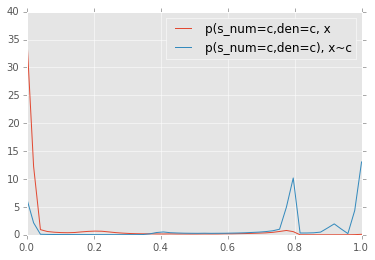

In [189]:
reals2 = np.linspace(0, 1)

cal_num, cal_den = cc_direct.classifier_.calibrators_[0]
plt.plot(reals2, cal_num.pdf(reals2.reshape(-1, 1)), 
         label="p(s_num=c,den=c, x")
plt.plot(reals2, cal_den.pdf(reals2.reshape(-1, 1)), 
        label="p(s_num=c,den=c), x~c")
plt.legend()
plt.show()


In [213]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

n_samples = 25000
def objective(theta, random_state=0):    
    print(theta)
    
    serie1, sampled1 = ricker(r=theta, sigma_2=sigma_2_value,phi=phi_value,n_timesteps=n_samples,start=0.5) 
    # Set parameter values   

    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=50))

    serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)

    
    X = np.hstack((
     serie1,
     serie2)).reshape((n_samples*2,1))
    y = np.zeros(n_samples*2, dtype=np.int)
    y[n_samples:] = 1

    max_len = 2
    X0_serie = []
    X1_serie = []

    serie1 = serie1.reshape(serie1.shape[0],1)
    serie2 = serie2.reshape(serie2.shape[0],1)
    for i in xrange(serie1.shape[0]-max_len):
        X0_serie.append(serie1[i:i+max_len])
        X1_serie.append(serie2[i:i+max_len])
    X0_serie = np.array(X0_serie)
    X1_serie = np.array(X1_serie)

    X_serie = np.vstack((
         X0_serie,
         X1_serie))
    y_serie = np.zeros(X0_serie.shape[0]*2,dtype=np.int)
    y_serie[X0_serie.shape[0]:] = 1

    
    ratio.fit(X_serie, y_serie)
    
    # Evaluate log-likelihood ratio
    r = ratio.predict(X_true_serie, log=True)
    print r[np.isfinite(r)].shape
    value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
                                         # this will need to be rescaled by len(X_true)
            
    return value

In [214]:
from GPyOpt.methods import BayesianOptimization
bounds = [(np.exp(3.3), np.exp(4.5))]
solver = BayesianOptimization(vectorize(objective), bounds)
solver.run_optimization(max_iter=50, true_gradients=False)

[ 65.99627376]
(1498,)
[ 85.76575092]
(1498,)
[ 34.20097716]
(1494,)
[ 43.53157067]
(1498,)
[ 46.68953849]
(1498,)
[ 46.16858858]
(1498,)
[ 45.99008023]
(1498,)
[ 45.88233796]
(1498,)
[ 45.87117318]
(1498,)
[ 45.69160501]
(1498,)
[ 45.63110872]
(1498,)
[ 45.68679075]
(1498,)
[ 45.57927001]
(1498,)
[ 45.66487725]
(1498,)
[ 45.56369576]
(1498,)
[ 45.57665914]
(1498,)
[ 43.95017065]
(1497,)
[ 45.63188662]
(1498,)
[ 45.49441502]
(1498,)
[ 45.87288834]
(1498,)
[ 45.26079579]
(1498,)
[ 45.71421873]
(1498,)
[ 45.5404734]
(1498,)
[ 45.75557922]
(1497,)
[ 45.28944944]
(1498,)
[ 45.44564856]
(1498,)
[ 45.65371013]
(1497,)
[ 45.39922846]
(1498,)
[ 45.34109827]
(1498,)
[ 45.785313]
(1498,)
[ 45.19759177]
(1498,)
[ 45.64259031]
(1498,)
[ 45.35287783]
(1498,)
[ 44.91953034]
(1498,)
[ 44.83386267]
(1498,)
[ 44.71280921]
(1498,)
[ 45.14097144]
(1498,)
[ 44.80178991]
(1497,)
[ 44.55018978]
(1498,)
[ 45.07752785]
(1498,)
[ 44.94732866]
(1498,)
[ 45.46063636]
(1498,)
[ 45.32735566]
(1498,)
[ 45.50396242]

1

In [215]:
approx_MLE = np.log(solver.x_opt)
print solver.x_opt
print("Approx. MLE =", approx_MLE)

[ 43.53157067]
('Approx. MLE =', array([ 3.77348644]))


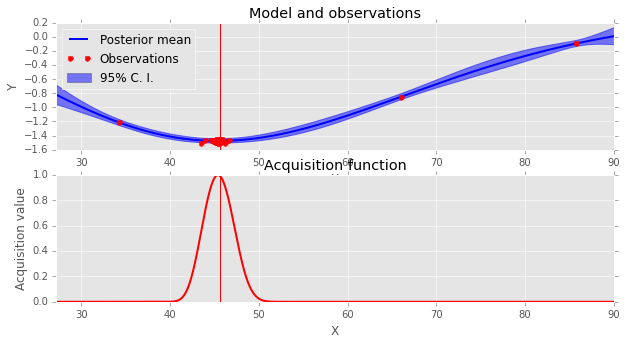

In [216]:
solver.plot_acquisition()

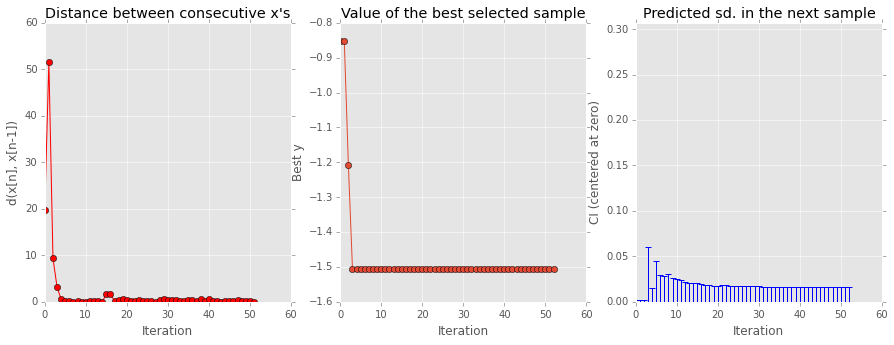

In [217]:
solver.plot_convergence()

In [218]:
from scipy.optimize import minimize

# Minimize the surrogate GP approximate of the approximate LR
def gp_objective(theta):
    theta = theta.reshape(1, -1)
    return solver.model.predict(theta)[0][0]

r = minimize(gp_objective, x0=[np.exp(4.)])
gp_MLE = r.x

print("GP MLE =", np.log(gp_MLE))

('GP MLE =', array([ 3.81538635]))


In [221]:
#bounds = [(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16)]
bounds = [(np.exp(3.3), np.exp(4.4))]
As = np.linspace(bounds[0][0],bounds[0][1], 50)

n_points = 30

clf = clf
n_samples = n_samples
#As = np.linspace(*bounds[0], 100)
nll_gp, var_gp = solver.model.predict(As.reshape(-1, 1))
print nll_gp
nll_gp = 2. * (nll_gp - nll_gp.min()) * len(X_true_serie)
gp_ratios = nll_gp
# STD
std_gp = np.sqrt(4*var_gp*len(X_true_serie)*len(X_true_serie))
std_gp[np.isnan(std_gp)] = 0.
gp_std = std_gp
# 95% CI
q1_gp, q2_gp = solver.model.predict_quantiles(As.reshape(-1, 1))
q1_gp = 2. * (q1_gp - r.fun) * len(X_true_serie)
q2_gp = 2. * (q2_gp - r.fun) * len(X_true_serie)
gp_q1 = q1_gp
gp_q2 = q2_gp

[[-0.81808637]
 [-0.88706263]
 [-0.9539614 ]
 [-1.01833942]
 [-1.07977249]
 [-1.13786009]
 [-1.19222986]
 [-1.24254154]
 [-1.28849058]
 [-1.32981122]
 [-1.36627895]
 [-1.39771252]
 [-1.4239752 ]
 [-1.44497554]
 [-1.46066742]
 [-1.4710495 ]
 [-1.47616413]
 [-1.47609563]
 [-1.47096806]
 [-1.46094258]
 [-1.44621431]
 [-1.42700889]
 [-1.40357878]
 [-1.3761993 ]
 [-1.34516458]
 [-1.31078343]
 [-1.27337523]
 [-1.23326591]
 [-1.19078405]
 [-1.14625723]
 [-1.10000858]
 [-1.05235367]
 [-1.00359773]
 [-0.9540332 ]
 [-0.90393774]
 [-0.85357249]
 [-0.80318087]
 [-0.75298768]
 [-0.70319854]
 [-0.65399974]
 [-0.60555838]
 [-0.55802274]
 [-0.511523  ]
 [-0.46617207]
 [-0.42206661]
 [-0.37928824]
 [-0.33790474]
 [-0.29797136]
 [-0.25953213]
 [-0.22262113]]


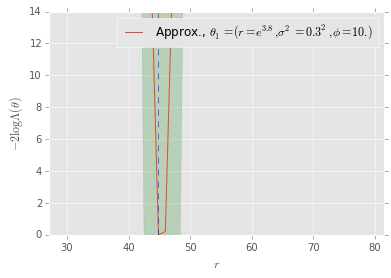

In [232]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(As, gp_ratios, label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=10.)$")
ax.fill_between(As,(gp_ratios - gp_std).ravel(),(gp_ratios + gp_std).ravel(),
                     color='g',alpha=0.2)
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$-2 \log \Lambda(\theta)$")
#plt.legend()


ax.legend()
ax.set_ylim(0, 14)
ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=np.exp(3.8),ymin=0.,ymax=14.,linestyle='dashed',alpha=0.5)
#plt.savefig('likelihood_comp.pdf')
plt.show()

TO-DO:
* 2D parameter estimation.
* Parameter estimation on $Y_t$ (here the method must be adapted for state space models).